# Spell checker with Attention

## Imports

In [1]:
import numpy as np
import re
import torch
from torch import nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from collections import Counter

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Word Tokenizer

In [3]:
START_OF_SENTENCE = "<s>"
END_OF_SENTENCE = "</s>"
UNKNOWN = "<UNK>"
INPUT_SENTENCE_LENGTH = 5
BATCH_SIZE = 8

class OneHotEncoder:
    def __init__(self, sos=START_OF_SENTENCE, eos=END_OF_SENTENCE, oov=UNKNOWN):
        self.sos = sos
        self.eos = eos
        self.oov = oov
        self.text_to_index = {}
        self.index_to_text = {}
        self.text_to_count = {}

    def fit_on_texts(self, text: str | list, max_num_of_elems=None):
        """"
        Text either as list of words (word embedding) or string (character embedding)
        """

        self.text_to_index = {}
        self.index_to_text = {}
        self.text_to_count = {}

        for elem in text:
            self.text_to_count[elem] = self.text_to_count.get(elem, 0) + 1
        
        if max_num_of_elems is None:
            max_num_of_elems = len(self.text_to_count)
        
        index = 3

        sorted_texts_by_counts = sorted(self.text_to_count.items(), key=lambda x: x[1], reverse=True)[:max_num_of_elems]
        for elem in [item[0] for item in sorted_texts_by_counts]:
            self.text_to_index[elem] = index
            index += 1
        
        self.text_to_index[self.eos] = 0
        self.text_to_index[self.sos] = 1
        self.text_to_index[self.oov] = 2
        self.index_to_text = {index: text for text, index in self.text_to_index.items()}
        

    def encode(self, text: str | list) -> torch.Tensor:
        """
        Creates an embedding tensor from the text / list of texts
        """
        encoding_list = [self.text_to_index.get(elem, self.text_to_index[self.oov]) for elem in text]
        return torch.tensor(encoding_list)


    def decode(self, embedding: torch.Tensor) -> list[str]:
        """
        Converts embedding back into text
        """
        decoding_list = [self.index_to_text[elem] for elem in embedding.tolist()]
        return decoding_list

In [4]:
def merge_items(all_tokens, pair, new_index):
    ix = np.where((all_tokens[:-1] == pair[0]) & (all_tokens[1:] == pair[1]))[0]
    all_tokens[ix] = new_index
    all_tokens = np.delete(all_tokens, ix+1)

    return all_tokens

### Test the word tokenizer

In [5]:
ohc = OneHotEncoder()
text = "This is a random text"
tokenized = re.sub("[^a-zA-Z+ ]", "", text).split() + [END_OF_SENTENCE]
ohc.fit_on_texts(tokenized)
ohc.decode(ohc.encode(tokenized))

['This', 'is', 'a', 'random', 'text', '</s>']

## Load and preprocess dataset

In [9]:
def normalize_sentence(sentence: str, lowercase=False, max_length=None):
    sentence = sentence.strip()
    if lowercase:
        sentence = sentence.lower()
    
    # Remove structure information in stylistic texts
    sentence = re.sub("V?I{1,3}\.", "", sentence)
    sentence = re.sub("^[a-gA-D123456]\)", "", sentence)

    # Remove hyper-links
    sentence = re.sub("https?\S+", "", sentence)
    sentence = re.sub("www\S+", "", sentence)

    # Remove emoticons
    sentence = re.sub("[:;\.=xX<][^a-zA-Z\s]*o*[\)\(\/oDP!3]+", "", sentence)

    sentence = re.sub('["“#$%&()*+\-\/;=@[\]^_`{|}~\t\n]+', "", sentence)
    sentence = re.sub("'", "", sentence)

    # Use separate tokens for interpunction
    sentence = re.sub("\.+", " .", sentence)
    sentence = re.sub(",+", " ,", sentence)
    sentence = re.sub(":+", " :", sentence)
    sentence = re.sub("\?+", " ?", sentence)
    sentence = re.sub("!+", " !", sentence)
    sentence = re.sub("  ", " ", sentence)


    """
    sentence = re.sub("á", "a", sentence)
    sentence = re.sub("[éě]", "e", sentence)
    sentence = re.sub("í", "i", sentence)
    sentence = re.sub("ý", "y", sentence)
    sentence = re.sub("ó", "o", sentence)
    sentence = re.sub("[ůú]", "u", sentence)
    sentence = re.sub("č", "c", sentence)
    sentence = re.sub("ď", "d", sentence)
    sentence = re.sub("ň", "n", sentence)
    sentence = re.sub("ř", "r", sentence)
    sentence = re.sub("š", "s", sentence)
    sentence = re.sub("ť", "t", sentence)
    sentence = re.sub("ž", "z", sentence)
    """

    sentence_tokens = sentence.strip().split(" ")
    if max_length is None:
        max_length = len(sentence_tokens) + 1
    
    return [[START_OF_SENTENCE] + sentence_tokens[i:i+max_length-2] + [END_OF_SENTENCE] for i in range(0, len(sentence_tokens), max_length-2)]
    
    return [sentence_tokens[i:i+max_length-1] + [END_OF_SENTENCE] for i in range(0, len(sentence_tokens), max_length-1)]
    

In [10]:
def tokenize_dataset(data_type="train"):
    with open(f"data/{data_type}/sentence.input", encoding="UTF-8") as input_file:
        input_lines = input_file.readlines()
    
    with open(f"data/{data_type}/sentence.gold", encoding="UTF-8") as input_file:
        golden_lines = input_file.readlines()

    input_tokens = []
    gold_tokens = []
    for input_line, golden_line in zip(input_lines, golden_lines):
        for golden_choice in golden_line.split("\t"):
            normalized_choice = normalize_sentence(golden_choice, lowercase=True, max_length=INPUT_SENTENCE_LENGTH)
            #INPUT_SENTENCE_LENGTH)

            if len(normalized_choice[0]) > 3 or len(normalized_choice[0][0]) > 4:
                # Ignore short and empty sentences
                normalized_input = normalize_sentence(input_line, lowercase=True, max_length=INPUT_SENTENCE_LENGTH)
                #INPUT_SENTENCE_LENGTH)
                # If splits of input and golden have different lengths, add trailing tokens accordingly 
                while len(normalized_input) < len(normalized_choice):
                    normalized_input.append([START_OF_SENTENCE])
                while len(normalized_choice) < len(normalized_input):
                    normalized_choice.append([START_OF_SENTENCE])
                input_tokens += normalized_input
                gold_tokens += normalized_choice

    return input_tokens, gold_tokens

In [11]:
train_input, train_golden = tokenize_dataset("train")

In [12]:
train_input_flattened = np.concatenate(train_input).ravel()
train_golden_flattened = np.concatenate(train_golden).ravel()

### Dataset analysis

In [13]:
ct = Counter(train_input_flattened)

In [15]:
print("Number of tokens: ", len(train_input_flattened))
print("Number of types (unique tokens):", len(ct.keys()))
print("Most common tokens: \n\t", "\n\t".join(map(str, ct.most_common(20))))

Number of tokens:  1420319
Number of types (unique tokens): 71016
Most common tokens: 
	 ('<s>', 308755)
	('</s>', 295504)
	('.', 58087)
	(',', 42458)
	('a', 29774)
	('se', 17229)
	('na', 14527)
	('je', 13529)
	('v', 12279)
	('to', 10285)
	('jsem', 8975)
	('že', 7004)
	('do', 5918)
	('ale', 5400)
	('si', 5049)
	('s', 4625)
	('tak', 4380)
	('?', 3938)
	('jsme', 3647)
	('když', 3601)


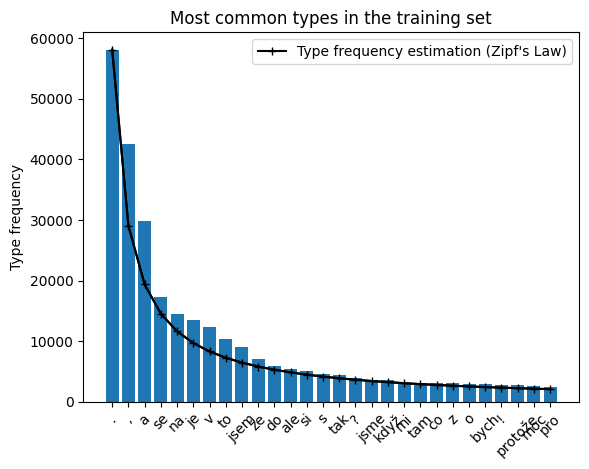

In [16]:
x, y = list(zip(*ct.most_common(30)[2:]))  # Ignore <s> and </s>
zipf_y = [(1/n**1) * y[0] for n in range(1, len(x) + 1)]

plt.bar(x, y)
plt.plot(x, zipf_y, color="black")
plt.plot(x, zipf_y, color="black", marker="+", label="Type frequency estimation (Zipf's Law)")
plt.legend()
plt.xticks(rotation=45)
plt.ylabel("Type frequency")
plt.title("Most common types in the training set")
None

In [18]:
sorted_values = sorted(ct.items(), key=lambda x: x[1], reverse=True)

In [19]:
percentile = 0.9
counts = np.array(list(reversed([x[1] for x in sorted_values])))
count_treshold = np.quantile(counts, 1 - percentile)

print(f"{percentile} percentile (type frequency): {count_treshold:.0f}")
print(f"Number of types below the {percentile} percentile: ", len([x for x in counts if x > count_treshold]))
print(f"Number of types above the {percentile} percentile: ", len([x for x in counts if x <= count_treshold]))


0.9 percentile (type frequency): 1
Number of types below the 0.9 percentile:  41086
Number of types above the 0.9 percentile:  29930


<BarContainer object of 49 artists>

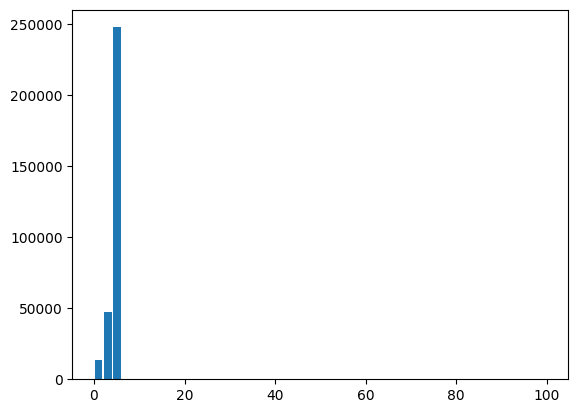

In [20]:
sentence_length_hist = np.histogram(list(map(len, train_input)), bins=np.linspace(0, 100, 50))
bin_edges = sentence_length_hist[1]
centers = (bin_edges[:-1] + bin_edges[1:]) / 2
width = 0.8*(centers[1] - centers[0])
plt.bar(centers, sentence_length_hist[0], width=width)

### Tensor creation

In [21]:
from torch.nn.utils.rnn import pad_sequence

In [58]:
VOCABULARY_LENGTH = 30_000
tokenizer = OneHotEncoder()
tokenizer.fit_on_texts(np.concatenate([train_input_flattened, train_golden_flattened]), max_num_of_elems=VOCABULARY_LENGTH)

VOCABULARY_LENGTH = max(tokenizer.text_to_index.values()) + 1
START_OF_SENTENCE_INDEX = tokenizer.text_to_index[START_OF_SENTENCE]
END_OF_SENTENCE_INDEX = tokenizer.text_to_index[END_OF_SENTENCE]

In [23]:
train_input_tensor = pad_sequence([tokenizer.encode(sentence) for sentence in train_input], batch_first=True)
train_golden_tensor = pad_sequence([tokenizer.encode(sentence) for sentence in train_golden], batch_first=True)

In [24]:
# Check if the embedding was successful
[tokenizer.decode(x) for x in train_input_tensor[:8]]

[['<s>', 'jak', 'v', 'bělorusku', '</s>'],
 ['<s>', 'slaví', 'vánoce', '?', '</s>'],
 ['<s>', 'musím', 'přiznat', ',', '</s>'],
 ['<s>', 'že', 'já', 'o', '</s>'],
 ['<s>', 'tom', 'mnoho', 'nevím', '</s>'],
 ['<s>', '.', '</s>', '</s>', '</s>'],
 ['<s>', 'nebo', 'nevím', 'nějaké', '</s>'],
 ['<s>', '<UNK>', 'běloruské', 'národní', '</s>']]

## Mini-batch dataloader

In [25]:
from torch.utils.data import DataLoader, RandomSampler, TensorDataset

In [26]:
train_data = TensorDataset(
    torch.LongTensor(train_input_tensor).to(device),
    torch.LongTensor(train_golden_tensor).to(device)
)
sampler = RandomSampler(train_data)
data_loader = DataLoader(train_data, batch_size=BATCH_SIZE, sampler=sampler)

## RNN Model

In [27]:
class Encoder(torch.nn.Module):
    def __init__(self, input_size: int, hidden_size: int, num_layers: int = 1, dropout_p=0.1):
        super(Encoder, self).__init__()

        self.input_dim = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.embedding = torch.nn.Embedding(input_size, hidden_size)
        self.model = torch.nn.GRU(hidden_size, hidden_size, num_layers, batch_first=True)
        self.dropout = torch.nn.Dropout(dropout_p)

    def forward(self, x):
        embeddings = self.dropout(self.embedding(x))
        outputs, hidden = self.model(embeddings)
        return outputs, hidden

In [28]:
class Decoder(torch.nn.Module):
    def __init__(self, output_size: int, hidden_size: int, num_layers: int = 1):
        super(Decoder, self).__init__()

        self.output_size = output_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.embedding = torch.nn.Embedding(output_size, hidden_size)
        self.model = torch.nn.GRU(hidden_size, hidden_size, num_layers, batch_first=True)
        self.out = torch.nn.Linear(hidden_size, output_size)

    def forward(self, encoder_outputs, encoder_hidden, target_tensor=None):
        batch_size = encoder_outputs.size(0)
        decoder_input = torch.empty(batch_size, 1, dtype=torch.long, device=device).fill_(START_OF_SENTENCE_INDEX)
        decoder_hidden = encoder_hidden
        decoder_outputs = []

        for i in range(INPUT_SENTENCE_LENGTH):
            decoder_output, decoder_hidden = self.forward_step(decoder_input, decoder_hidden)
            decoder_outputs.append(decoder_output)

            if target_tensor is not None:
                #print(target_tensor.shape)

                decoder_input = target_tensor[:, i].unsqueeze(1)#[:, i].unsqueeze(1)
                #print(decoder_input.shape)
            else:
                _, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze(-1).detach()
                #print(decoder_input.shape)

        decoder_outputs = torch.cat(decoder_outputs, dim=1)
        decoder_output = torch.nn.functional.log_softmax(decoder_outputs, dim=-1)
        return decoder_outputs, decoder_hidden, None
    
    def forward_step(self, input, hidden):
        output = self.embedding(input)
        output = torch.nn.functional.relu(output)
        
        output, hidden = self.model(output, hidden)
        
        output = self.out(output)
        return output, hidden

In [29]:
train_input_tensor[[0], :]

tensor([[   1,   43,   11, 4839,    0]])

In [31]:
# This cell sometimes throws an error as it creates a token index outside the dictionary.

testing_tensor = train_input_tensor[[0], :]
testing_tensor_y = train_golden_tensor[[0], :]


learning_rate = 0.01
encoder = Encoder(VOCABULARY_LENGTH, 128, 1)
decoder = Decoder(VOCABULARY_LENGTH, 128, 1)

loss = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(encoder.parameters(), lr=learning_rate)


encoded_sentences = encoder(testing_tensor)
decoded_result, _, _ = decoder(encoded_sentences[0], encoded_sentences[1], testing_tensor_y)

tokenizer.decode(torch.argmax(decoded_result[0, :,:], dim=1))

['operuju', 'operuju', 'strašný', 'kdyř', 'migrantů']

### Epoch training

In [33]:
encoder = Encoder(VOCABULARY_LENGTH, 128, 1)
decoder = Decoder(VOCABULARY_LENGTH, 128, 1)

criterion = torch.nn.NLLLoss()
optimizer_encoder = torch.optim.Adam(encoder.parameters(), lr=learning_rate)
optimizer_decoder = torch.optim.Adam(decoder.parameters(), lr=learning_rate)

In [36]:
EPOCHS = 20

learning_rate = 0.5 # 0.001

for epoch_num in range(1, EPOCHS + 1):
    epoch_loss = 0
    
    used_input_tensors = []
    used_target_tensors = []
    for input_tensor, target_tensor in data_loader:

        used_input_tensors.append(input_tensor)
        used_target_tensors.append(target_tensor)
        
        optimizer_encoder.zero_grad()
        optimizer_decoder.zero_grad()

        encoder_outputs, encoder_hidden = encoder(input_tensor)        
        decoder_outputs, _, _ = decoder(encoder_outputs, encoder_hidden, target_tensor)

        loss = criterion(
            decoder_outputs.view(-1, decoder_outputs.size(-1)),
            target_tensor.view(-1)
        )
        loss.backward()
        optimizer_encoder.step()
        optimizer_decoder.step()

        epoch_loss += loss.item()

    print(epoch_loss / (len(data_loader) * BATCH_SIZE))


-0.005757335826420602
-0.005699361422346391
-0.005542950927323204
-0.005475501801655969
-0.006093393111571791
-0.006199123828827154
-0.0058248308134567
-0.006050254959163772
-0.0064038197230390816
-0.006438596576958034
-0.00646133274592827
-0.006881729384935154
-0.006797082542461934
-0.006492182720138366
-0.00665356116771142
-0.0071025853824825515
-0.006561943792527722
-0.007164048116925868
-0.007281332143246625
-0.007536528224478053


## Bahdanau Attention Layer

In [42]:
class BahdanauAttention(nn.Module):
    def __init__(self, hidden_size):
        super(BahdanauAttention, self).__init__()
        self.Wa = nn.Linear(hidden_size, hidden_size)
        self.Ua = nn.Linear(hidden_size, hidden_size)
        self.Va = nn.Linear(hidden_size, 1)

    def forward(self, query, keys):
        scores = self.Va(torch.tanh(self.Wa(query) + self.Ua(keys)))
        scores = scores.squeeze(2).unsqueeze(1)

        weights = F.softmax(scores, dim=-1)
        context = torch.bmm(weights, keys)

        return context, weights

class AttnDecoderRNN(nn.Module):
    def __init__(self, output_size, hidden_size, dropout_p=0.1):
        super(AttnDecoderRNN, self).__init__()
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.attention = BahdanauAttention(hidden_size)
        self.gru = nn.GRU(2 * hidden_size, hidden_size, batch_first=True)
        self.out = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, encoder_outputs, encoder_hidden, target_tensor=None):
        batch_size = encoder_outputs.size(0)
        decoder_input = torch.empty(batch_size, 1, dtype=torch.long, device=device).fill_(START_OF_SENTENCE_INDEX)
        decoder_hidden = encoder_hidden
        decoder_outputs = []
        attentions = []

        for i in range(INPUT_SENTENCE_LENGTH):
            decoder_output, decoder_hidden, attn_weights = self.forward_step(
                decoder_input, decoder_hidden, encoder_outputs
            )
            decoder_outputs.append(decoder_output)
            attentions.append(attn_weights)

            if target_tensor is not None:
                # Teacher forcing: Feed the target as the next input
                decoder_input = target_tensor[:, i].unsqueeze(1) # Teacher forcing
            else:
                # Without teacher forcing: use its own predictions as the next input
                _, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze(-1).detach()  # detach from history as input

        decoder_outputs = torch.cat(decoder_outputs, dim=1)
        decoder_outputs = F.log_softmax(decoder_outputs, dim=-1)
        attentions = torch.cat(attentions, dim=1)

        return decoder_outputs, decoder_hidden, attentions


    def forward_step(self, input, hidden, encoder_outputs):
        embedded =  self.dropout(self.embedding(input))

        query = hidden.permute(1, 0, 2)
        context, attn_weights = self.attention(query, encoder_outputs)
        input_gru = torch.cat((embedded, context), dim=2)

        output, hidden = self.gru(input_gru, hidden)
        output = self.out(output)

        return output, hidden, attn_weights

In [43]:
encoder = Encoder(VOCABULARY_LENGTH, 128, 1)
decoder = AttnDecoderRNN(VOCABULARY_LENGTH, 128)

criterion = torch.nn.NLLLoss()
optimizer_encoder = torch.optim.Adam(encoder.parameters(), lr=learning_rate)
optimizer_decoder = torch.optim.Adam(decoder.parameters(), lr=learning_rate)

In [44]:
EPOCHS = 5
used_batches = 1000
learning_rate = 0.001

for epoch_num in range(1, EPOCHS + 1):
    epoch_loss = 0
    
    used_input_tensors = []
    used_target_tensors = []

    for _ in range(used_batches):
        input_tensor, target_tensor = next(iter(data_loader))

        used_input_tensors.append(input_tensor)
        used_target_tensors.append(target_tensor)
        
        optimizer_encoder.zero_grad()
        optimizer_decoder.zero_grad()

        encoder_outputs, encoder_hidden = encoder(input_tensor)        
        decoder_outputs, _, _ = decoder(encoder_outputs, encoder_hidden, target_tensor)

        #print(target_tensor.view(-1).shape, decoder_outputs.view(-1, decoder_outputs.size(-1)).shape)
        loss = criterion(
            decoder_outputs.view(-1, decoder_outputs.size(-1)),
            target_tensor.view(-1)
        )
        loss.backward()
        optimizer_encoder.step()
        optimizer_decoder.step()

        epoch_loss += loss.item()
    print(epoch_loss / (len(data_loader) * BATCH_SIZE))


0.00045415121187955575
0.000674406749193093
0.0005507843592327823
0.0007011716454460578
0.0008087987093005654


In [45]:
def evaluate(encoder, decoder, input_tensor):
    with torch.no_grad():

        encoder_outputs, encoder_hidden = encoder(input_tensor)
        decoder_outputs, _, decoder_attn = decoder(encoder_outputs, encoder_hidden)

        _, topi = decoder_outputs.topk(1)
        decoded_ids = topi.squeeze()
        decoded_words = [tokenizer.decode(decoded) for decoded in decoded_ids]
    return decoded_words, decoder_attn

In [46]:
def evaluate_sentence(encoder, decoder, sentence, target_sentence, tokenizer):
    input_lists = [tokenizer.encode(split_sentence) for split_sentence in normalize_sentence(sentence)]
    input_tensors = pad_sequence(input_lists, batch_first=True)
    output_sentence, attns = evaluate(encoder, decoder, input_tensors)
    print("In:", sentence)
    print("Should:", target_sentence)
    print("Out:", " ".join(sum(output_sentence, [])))

In [59]:
evaluate_sentence(encoder, decoder, "V Bělorusku slaví Vánoce", "V Bělorusku slaví Vánoce", tokenizer)

In: V Bělorusku slaví Vánoce
Should: V Bělorusku slaví Vánoce
Out: <s> <s> <s> <s> spolu spolu hrníčku hrníčku proto kámen


### Manual result check

In [60]:
single_input_tensor = used_input_tensors[0]
single_target_tensor = used_target_tensors[0]

tokenizer.decode(single_input_tensor[0])
tokenizer.decode(single_target_tensor[0])
[tokenizer.decode(x) for x in single_input_tensor]


[['<s>', 'všechny', 'stálo', '.', '</s>'],
 ['<s>', 'bokem', '.', '</s>', '</s>'],
 ['<s>', 'nejvzácnější', 'objevy', 'patřily', '</s>'],
 ['<s>', 'spolu', 'až', 'v', '</s>'],
 ['<s>', ':d', '.ten', '</s>', '</s>'],
 ['<s>', 'kdíš', 'přídu', '<UNK>', '</s>'],
 ['<s>', 'pavla', ',', 'petra', '</s>'],
 ['<s>', '<UNK>', 'až', '<UNK>', '</s>']]